<a href="https://colab.research.google.com/github/DimpleB0501/Assignment_cifar10_resnet/blob/main/Assignment_CIFAR10_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment
Write a custom ResNet architecture for CIFAR10.

-   Atleast two resnet blocks

-   Initial conv block and final fully connected/Global avg pooling layer plus  any number of downscale/conv layers you might want to include

-          3x3 convolutions

-          <5 million params


Use One Cycle Learning rate Policy and determine max learning rate to use.

Uses this transform -RandomCrop 32, 32 (after padding of 4),  FlipLR, Followed by CutOut(8, 8)

Target test accuracy 90% within 25 epochs

Nice to have: use gradcam to find heatmaps for 10 incorrect labelled images.

Share code for augmentation, model definition, learning rate determination, and train/test logs.

In [1]:
#!kill -9 -1

In [2]:
!pip3 install numpy
!pip3 install torch torchvision
!pip3 install matplotlib

# Import package

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F



import numpy as np
import matplotlib.pyplot as plt

In [4]:
print ("Pytorch version:", torch.__version__)

Pytorch version: 1.10.0+cu111


# GPU mode

In [5]:
# Check if GPU available
if torch.cuda.is_available():
  print ("On GPU")
else :
  print ("No GPU available")

On GPU


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Loading CIFAR-10 dataset

In [7]:
batch_size = 64

### Transform
- RandomCrop 32, 32 (after padding of 4)
- FlipLR using RandomHorizontalFlip() instead
- Followed by CutOut(8, 8)



In [8]:
class Cutout(object): # based on github code on Code
    """Randomly mask out one or more patches from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes=8, length=8):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

In [9]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
# Transforms
train_transform = transforms.Compose(
    [transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     normalize])

#train_transform.transforms.append(Cutout(8, 2))

test_transform = transforms.Compose([
                    transforms.ToTensor(),
                    normalize])

# CIFAR-10 dataset

In [10]:
# Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [11]:
# Data loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Plot training images

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
def show_batch(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [13]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [14]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print ("Image shape: ", images[0].shape) # use to determine the number of parameters for the model

Image shape:  torch.Size([3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


                    cat                     cat                     dog                    bird                   plane


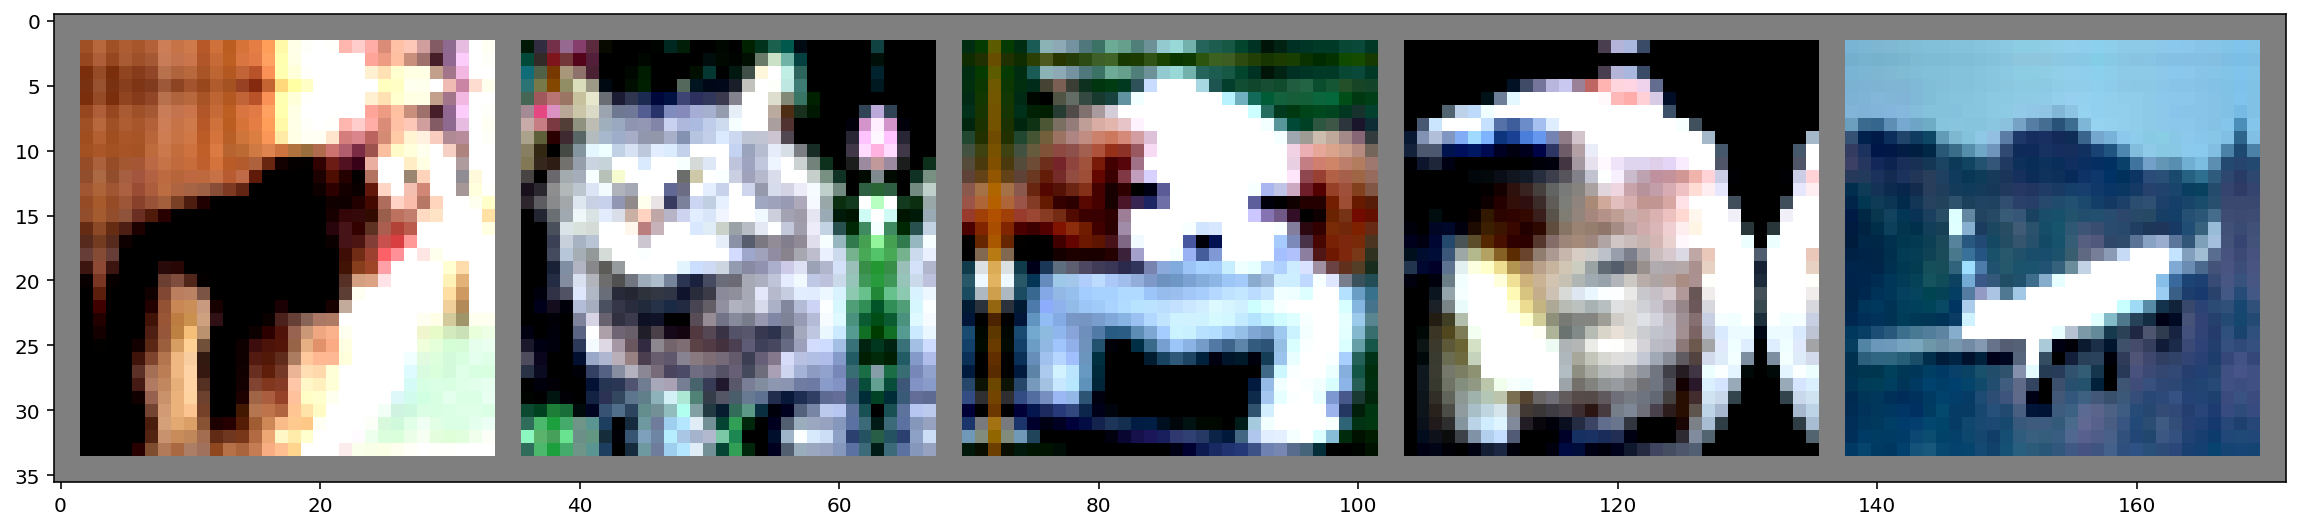

In [15]:
plt.figure(figsize = (20, 20))

# show images
show_batch(torchvision.utils.make_grid(images[0:5,:,:]))
# print labels
print(' '.join('%23s' % classes[labels[j]] for j in range(5)))

# Custom ResNet architecture implementation

In [16]:
class block(nn.Module):
  def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1): # identity downsample (conv layer) is used in case we have changed the input size or change number of channels
    super(block, self).__init__()
    self.expansion = 4 # number of channels after a block is 4 times what it was when it entered
    
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = 1, padding = 0)
    self.bn1 = nn.BatchNorm2d(out_channels)

    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = stride, padding = 1)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size = 1, stride = 1, padding = 0)
    self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)

    self.relu = nn.ReLU()
    self.identity_downsample = identity_downsample
    self.stride = stride

  def forward(self,x):
    identity = x.clone()

    x = self.conv1(x)
    x = self.bn1(x)

    x = self.conv2(x)
    x = self.bn2(x)

    x = self.conv3(x)
    x = self.bn3(x)

    if self.identity_downsample is not None:
      identity  = self.identity_downsample(identity)

    x += identity # y = x + f(x), reducing the error function f(x) so that input becomes equal to output
    x = self.relu(x)

    return x

In [17]:
class ResNet(nn.Module): 
  def __init__(self, block, layers, image_channels, num_classes): # block is residual block , layers tells us how many times we want to use the block, Resnet50 [3, 4, 6, 3], image channels (3 in case of RGB data), number of classes 10 for cifar10
    super(ResNet, self).__init__()
    self.in_channels = 64
    self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()

    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # ResNet layers
    self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride = 1)
    self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride = 2)
    self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride = 2)
    #self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride = 2)

    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    #print ("here")
    self.fc = nn.Linear(256*4, num_classes) # number of channels times expansion(4)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    #x = self.layer4(x)

    x = self.avgpool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fc(x)
    return x

  def _make_layer(self, block, num_residual_blocks, out_channels, stride): # number of times the blocks are used.
    identity_downsample = None
    layers = []

    # identity_downsample is changed either when we change the input size or input channels is not equal to out channels
    if stride != 1 or self.in_channels != out_channels * 4:
      identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    out_channels * 4,
                    kernel_size=1,
                    stride=stride,
                ),
                nn.BatchNorm2d(out_channels * 4),
            )
      
    layers.append(block(self.in_channels, out_channels, identity_downsample, stride))  
    self.in_channels = out_channels*4

    for i in range(num_residual_blocks - 1):
      layers.append(block(self.in_channels, out_channels))

    return nn.Sequential(*layers)

In [18]:
def ResNetCustom(img_channels, num_classes=10):
  return ResNet(block, [3,3,3], img_channels, num_classes)

In [19]:
from torchsummary import summary

net = ResNetCustom(img_channels=3, num_classes=10).to(device)
summary(net, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,472
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,160
       BatchNorm2d-6             [-1, 64, 8, 8]             128
            Conv2d-7             [-1, 64, 8, 8]          36,928
       BatchNorm2d-8             [-1, 64, 8, 8]             128
            Conv2d-9            [-1, 256, 8, 8]          16,640
      BatchNorm2d-10            [-1, 256, 8, 8]             512
           Conv2d-11            [-1, 256, 8, 8]          16,640
      BatchNorm2d-12            [-1, 256, 8, 8]             512
             ReLU-13            [-1, 256, 8, 8]               0
            block-14            [-1, 25

In [20]:
from functools import reduce
def pytorch_count_params(model):
  "count number trainable parameters in a pytorch model"
  total_params = sum(reduce( lambda a, b: a*b, x.size()) for x in model.parameters())
  return total_params

In [21]:
print("Total number of trainable parameters in ResNetCustom: ", pytorch_count_params(net))

Total number of trainable parameters in ResNetCustom:  4931850


# Train

In [22]:
# Hyperparameters
num_epochs = 25 # change to 25
max_learning_rate = 0.005 #0.025 # change to 0.01

In [23]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=max_learning_rate)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_learning_rate, epochs=num_epochs, 
                                                steps_per_epoch=len(trainloader))

In [24]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [25]:
# Train the model
total_step = len(trainloader)
# keeping-track-of-losses 
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
  train_loss = 0.0
  valid_loss = 0.0
  lrs = []

  # training the model
  net.train()
  for i, (images, labels) in enumerate(trainloader):
        images = images.to(device)
        labels = labels.to(device)

        # clear all gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(images)
        loss = criterion(outputs, labels)

        # Backward and optimize        
        loss.backward()

        
        optimizer.step()
        train_loss += loss.item() * images.size(0)
                 
        # record and update learning rate
        lrs.append(get_lr(optimizer))
        scheduler.step()

  # validate the model 
  net.eval()
  for i, (images, labels) in enumerate(testloader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        # update validation loss
        valid_loss += loss.item() * images.size(0)

  # calculate-average-losses
  train_loss = train_loss/len(trainloader.sampler)
  valid_loss = valid_loss/len(testloader.sampler)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  print ("Epoch: {}, \t  Train Loss: {:.4f}, \t  Valid Loss: {:.4f}, \t learning_rate: {:.8f}"
                   .format(epoch+1, train_loss, valid_loss,lrs[-1]))
   

Epoch: 1, 	  Train Loss: 1.4242, 	  Valid Loss: 1.1542, 	 learning_rate: 0.00040704
Epoch: 2, 	  Train Loss: 1.1898, 	  Valid Loss: 1.2359, 	 learning_rate: 0.00099339
Epoch: 3, 	  Train Loss: 1.1304, 	  Valid Loss: 1.1508, 	 learning_rate: 0.00185763
Epoch: 4, 	  Train Loss: 1.0546, 	  Valid Loss: 1.1250, 	 learning_rate: 0.00285027
Epoch: 5, 	  Train Loss: 0.9843, 	  Valid Loss: 0.9546, 	 learning_rate: 0.00379963
Epoch: 6, 	  Train Loss: 0.9158, 	  Valid Loss: 0.8755, 	 learning_rate: 0.00454149
Epoch: 7, 	  Train Loss: 0.8675, 	  Valid Loss: 0.8413, 	 learning_rate: 0.00494754
Epoch: 8, 	  Train Loss: 0.8058, 	  Valid Loss: 0.7720, 	 learning_rate: 0.00498994
Epoch: 9, 	  Train Loss: 0.7631, 	  Valid Loss: 0.7134, 	 learning_rate: 0.00490991
Epoch: 10, 	  Train Loss: 0.7221, 	  Valid Loss: 0.7042, 	 learning_rate: 0.00475242
Epoch: 11, 	  Train Loss: 0.6837, 	  Valid Loss: 0.6746, 	 learning_rate: 0.00452254
Epoch: 12, 	  Train Loss: 0.6470, 	  Valid Loss: 0.6438, 	 learning_rate: 

# Test the model

In [26]:
# Test the model
net.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))
# Save the model checkpoint
torch.save(net.state_dict(), 'resnet.ckpt')

Accuracy of the model on the test images: 86.55 %


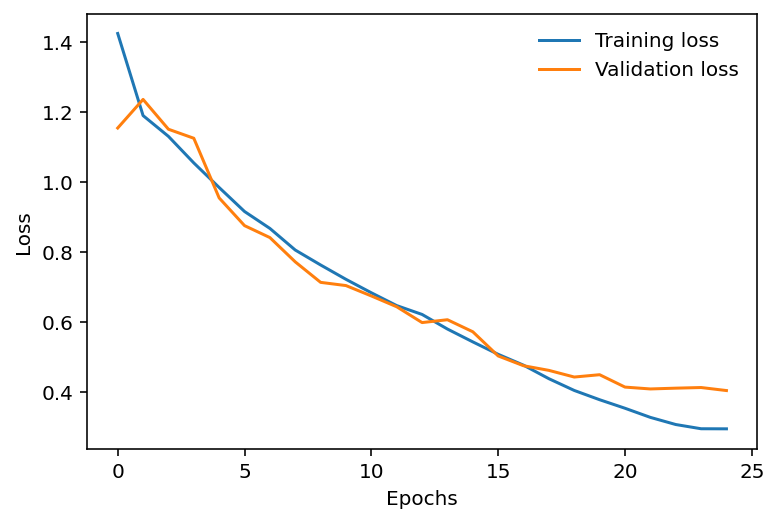

In [27]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

# Validate model on images

In [28]:
# Function to test the model with a batch of images and show the labels predictions
end_val = 5

def testBatch():
    # get batch of images from the test DataLoader  
    images, labels = next(iter(testloader))

    # show all images as one image grid
    show_batch(torchvision.utils.make_grid(images[:end_val]))
   
    # Show the real labels on the screen 
    print('Real labels: ', ' '.join('%5s' % classes[labels[j]] 
                               for j in range(end_val)))
  
    predicted_vals=[]
    for r in range(end_val):
      image_in = images[r].unsqueeze(0).to(device)
      # Let's see what if the model identifiers the  labels of those example
      outputs = net(image_in)        
    
      # We got the probability for every 10 labels. The highest (max) probability should be correct label
      _, predicted = torch.max(outputs, 1)
      predicted_vals.append(classes[predicted])
    
    # Let's show the predicted labels on the screen to compare with the real ones
    print('Predicted: ', ' '.join('%5s' % predicted_vals[j] for j in range(end_val)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Real labels:    cat  ship  ship plane  frog
Predicted:    cat  ship  ship plane  frog


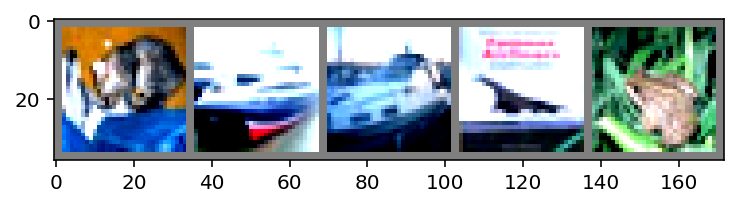

In [29]:
testBatch()

# Implementing grad cam on random image. Layer3 of resnet model

In [30]:
!pip3 install grad-cam

     |████████████████████████████████| 4.5 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.3.7-py3-none-any.whl size=25953 sha256=24c13d2e77f1cee73b5e6a5d81d282473d106052d75de7e3d89cc02a63ea7ff1
  Stored in directory: /root/.cache/pip/wheels/30/ab/9c/53c523785edffdc6c61755cf82e0dac3342d0d36190c187894
Successfully built grad-cam


In [31]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
#from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
import cv2
import random

In [32]:
def grad_cam_on_image(image_id=16):
  #print (image_id)

  plt.figure(figsize = (10, 10))

  img, _ = next(iter(testloader))
  img_tensor = img[image_id].unsqueeze(0).to(device)
  img=img[image_id].permute(1, 2, 0) 

  plt.subplot(1, 3, 1)
  plt.imshow(img)

  cam = GradCAM(model=net, target_layers=net.layer3)

  target_category = None

  grayscale_cam = cam(input_tensor=img_tensor)

  grayscale_cam = grayscale_cam[0, :]
  #print (grayscale_cam, len(grayscale_cam))
  #print (img, len(img))

  gb_model = GuidedBackpropReLUModel(model=net, use_cuda=True)
  gb = gb_model(img_tensor, target_category=None)
  cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
  cam_gb = deprocess_image(cam_mask * gb)
  gb = deprocess_image(gb)

  rgb_img = np.float32(img) / 255

  cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
  cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)
  plt.subplot(1, 3, 2)
  plt.imshow(cam_gb)

  plt.subplot(1, 3, 3)
  plt.imshow(cam_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


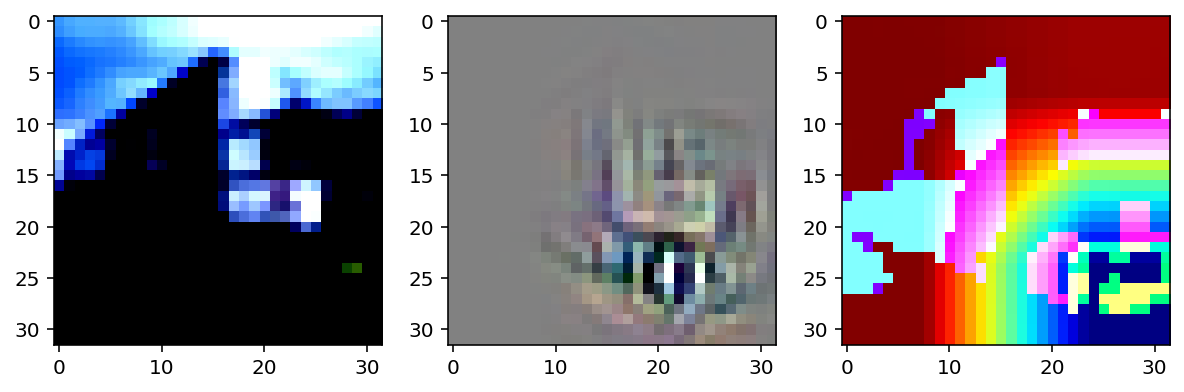

In [33]:
grad_cam_on_image(image_id = random.randint(1,50))

# Implementing gradcam on 10 incorrectly classified images

In [34]:
def test(dataloader):
    running_corrects = 0
    running_loss=0
    pred = []
    true = []
    pred_wrong = []
    true_wrong = []
    image = []
    sm = nn.Softmax(dim = 1)
    for batch_idx, (data, target) in enumerate(dataloader):
        data = data.type(torch.cuda.FloatTensor)
        target = target.type(torch.cuda.LongTensor)
        net.eval()
        output = net(data)
        loss = criterion(output, target)
        output = sm(output)
        _, preds = torch.max(output, 1)
        running_corrects = running_corrects + torch.sum(preds == target.data)
        running_loss += loss.item() * data.size(0)
        preds = preds.cpu().numpy()
        target = target.cpu().numpy()
        preds = np.reshape(preds,(len(preds),1))
        target = np.reshape(target,(len(preds),1))
        data = data.cpu().numpy()
        
        for i in range(len(preds)):
            pred.append(preds[i])
            true.append(target[i])
            if(preds[i]!=target[i]):
                pred_wrong.append(preds[i])
                true_wrong.append(target[i])
                image.append(data[i])
      
    epoch_acc = running_corrects.double()/(len(dataloader)*batch_size)
    epoch_loss = running_loss/(len(dataloader)*batch_size)
    print(epoch_acc,epoch_loss)
    return true,pred,image,true_wrong,pred_wrong

In [35]:
# To plot the wrong predictions given by model
def wrong_plot(n_figures,true,ima,pred,encoder,inv_normalize):
    print('Classes in order Actual and Predicted')
    #n_row = int(n_figures/3)

    for r in range(n_figures):
      plt.figure(figsize = (10, 10))
      a = random.randint(0,len(true)-1)
  
      image,correct,wrong = ima[a],true[a],pred[a]
      img_tensor = torch.from_numpy(image).unsqueeze(0).to(device)
      image = torch.from_numpy(image)
      correct = int(correct)
      c = encoder[correct]
      wrong = int(wrong)
      w = encoder[wrong]
      f = 'Actual:'+c + ',' +'Predicted:'+w
      if inv_normalize !=None:
          image = inv_normalize(image)
      image = image.numpy().transpose(1,2,0)
      plt.subplot(1, 3, 1)
      im = plt.imshow(image)
      plt.title(f)

      cam = GradCAM(model=net, target_layers=net.layer3)

      target_category = None

      grayscale_cam = cam(input_tensor=img_tensor)

      grayscale_cam = grayscale_cam[0, :]
      #print (grayscale_cam, len(grayscale_cam))
      #print (img, len(img))

      gb_model = GuidedBackpropReLUModel(model=net, use_cuda=True)
      gb = gb_model(img_tensor, target_category=None)
      cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
      cam_gb = deprocess_image(cam_mask * gb)
      gb = deprocess_image(gb)

      rgb_img = np.float32(image) / 255

      cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
      cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)
      plt.subplot(1, 3, 2)
      plt.imshow(cam_gb)

      plt.subplot(1, 3, 3)
      plt.imshow(cam_image)
      #ax.axis('off')
    plt.show()

In [36]:
encoder = {}
for i in range(len(classes)):
    encoder[i] = classes[i]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.8614, device='cuda:0', dtype=torch.float64) 0.4025254590780872
Classes in order Actual and Predicted


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


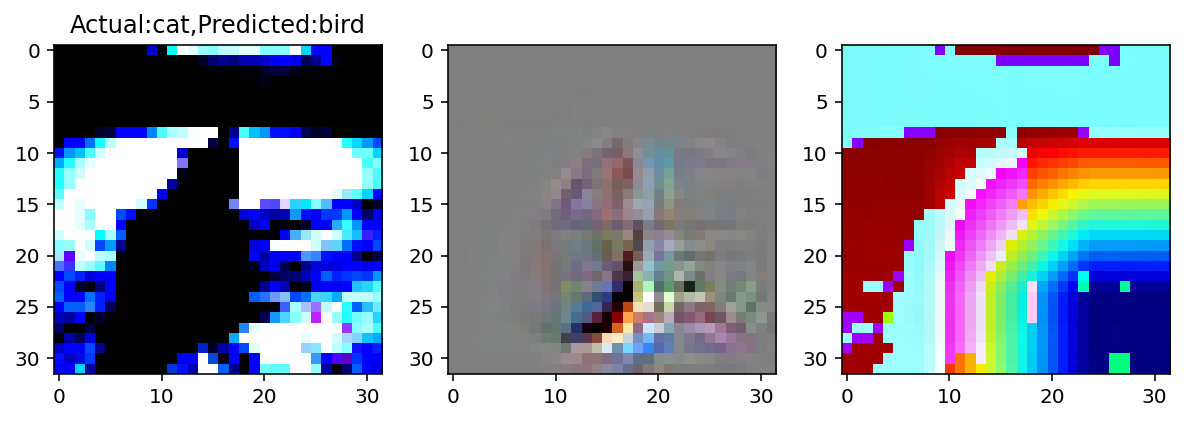

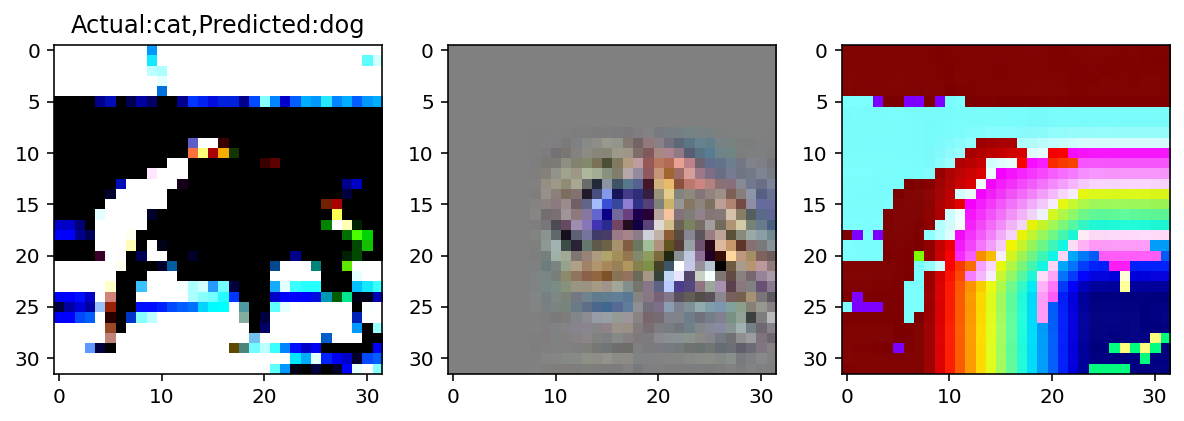

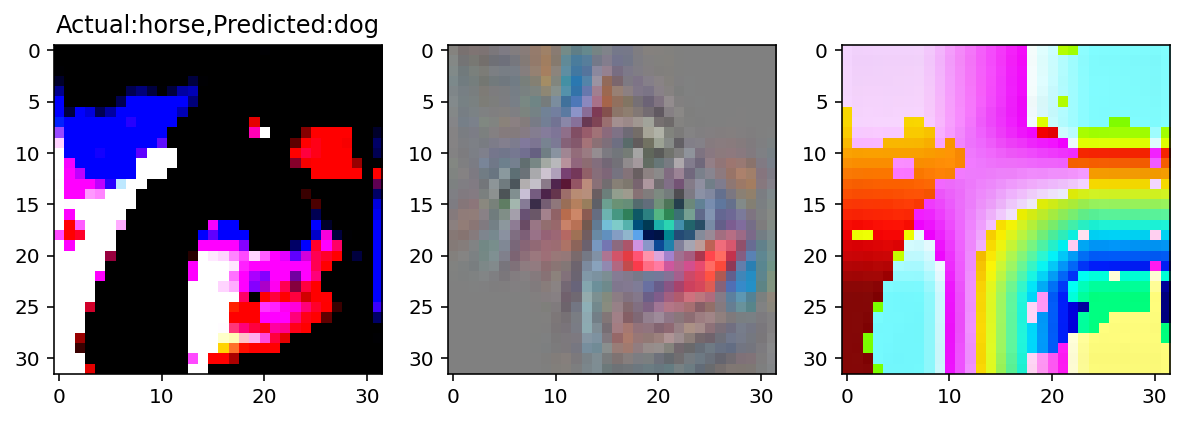

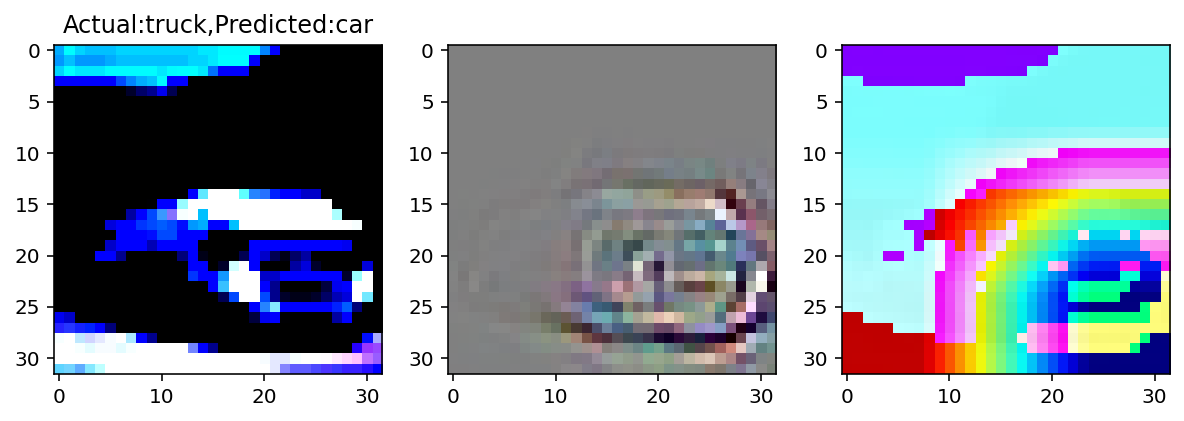

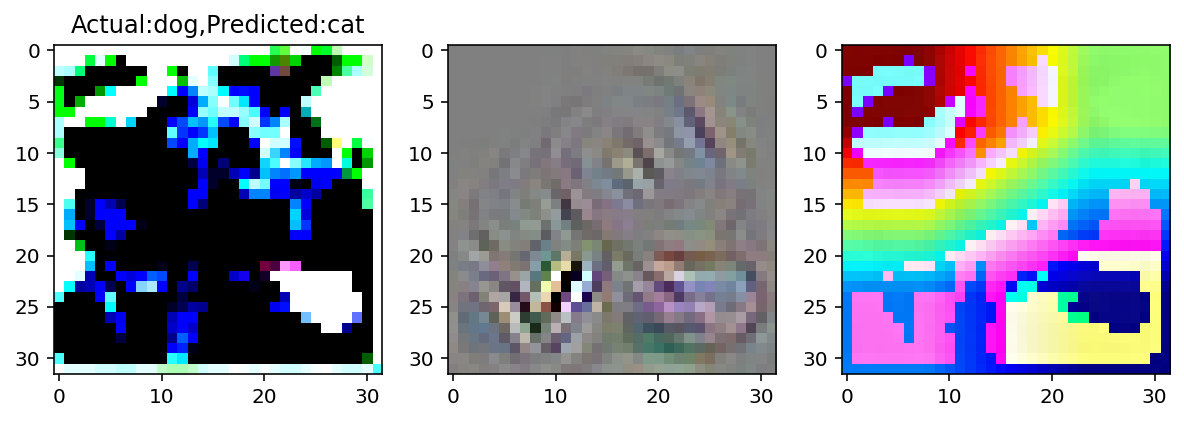

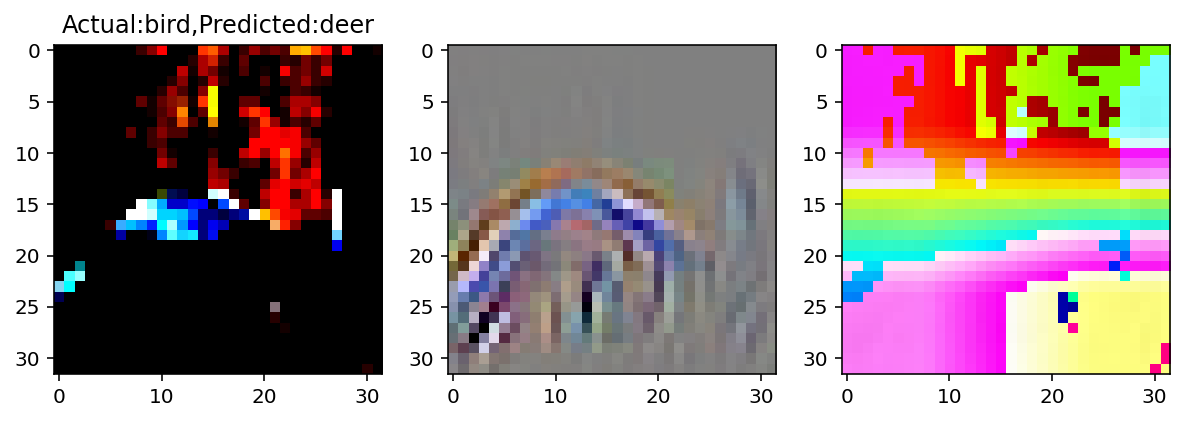

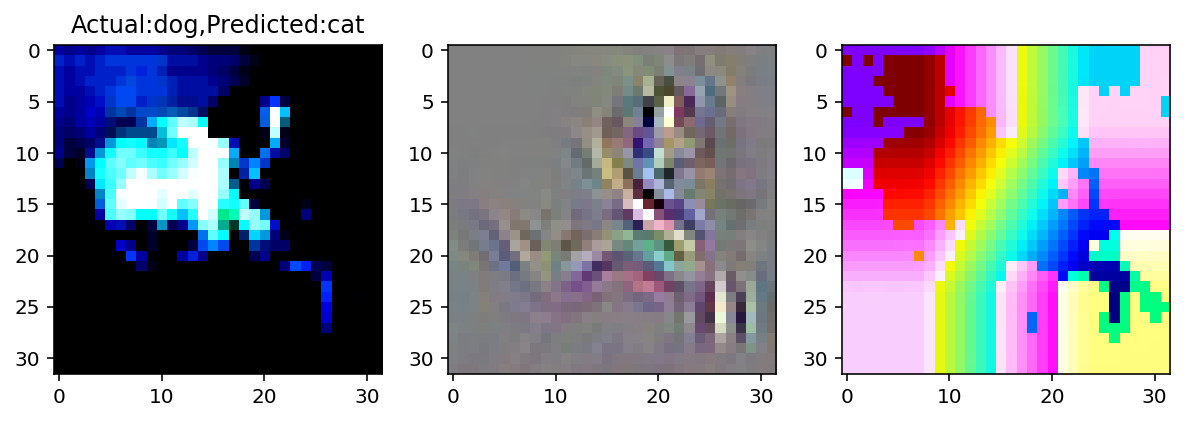

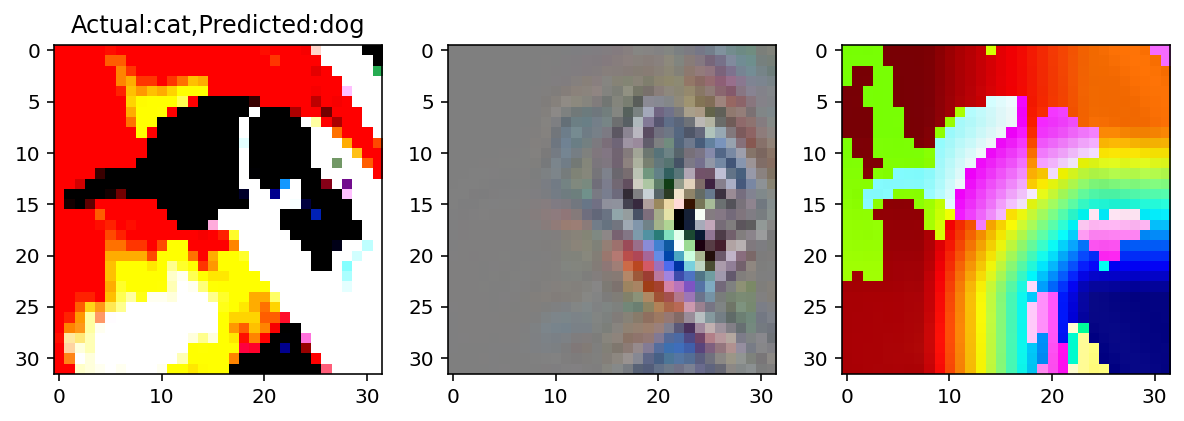

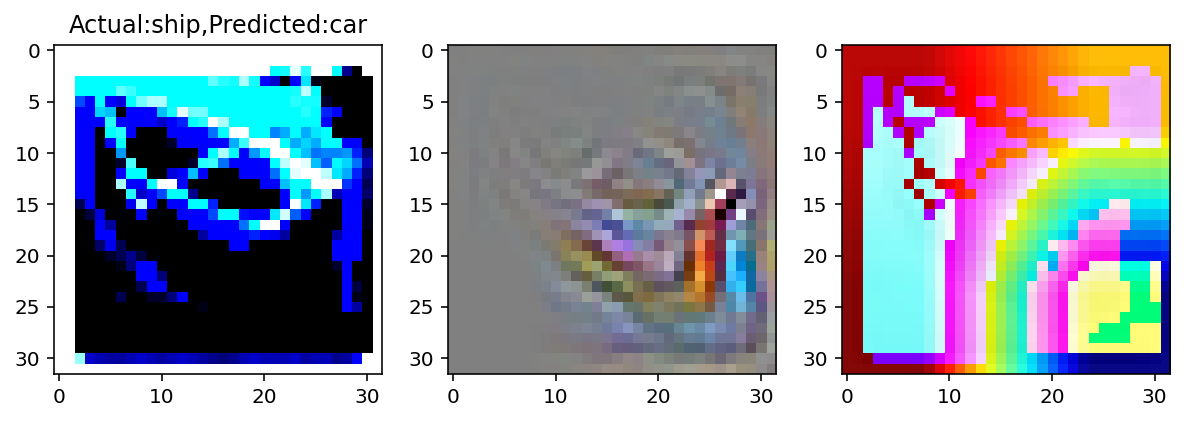

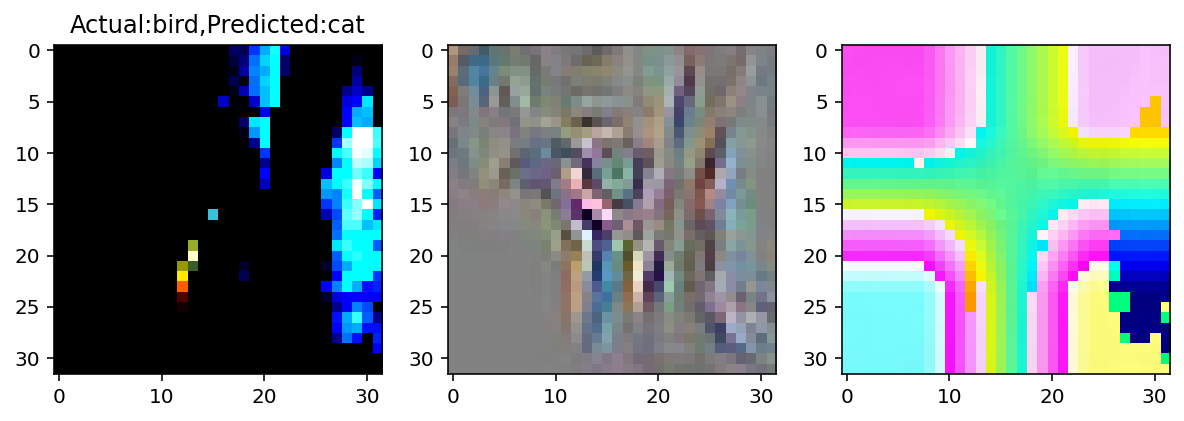

In [38]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
true,pred,image,true_wrong,pred_wrong = test(testloader)
wrong_plot(10,true_wrong,image,pred_wrong,encoder,normalize)